# Análise Investigativa dos Quadrantes de Decisão - Lei do Bem
## 1. Configuração Inicial e Carregamento dos Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
sns.set_style("whitegrid")

## 2. Carregamento e Primeira Exploração dos Dados

In [2]:
# Carregar o dataset
df = pd.read_csv('resultados_agrupamento/GRUPOS_FINAL_PROCESSADO.csv', sep=';', encoding='utf-8')

print("="*80)
print("INFORMAÇÕES BÁSICAS DO DATASET")
print("="*80)
print(f"Dimensões do dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"\nColunas disponíveis ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2}. {col}")
    
# Verificar tipos de dados das colunas principais
print("\n" + "="*80)
print("TIPOS DE DADOS DAS COLUNAS PRINCIPAIS")
print("="*80)
cols_of_interest = ['do_resultado_analise', 'p_resultado_analise', 
                   'setor', 'ano_referencia', 'similaridade_score',
                   'tipo_pesquisa', 'natureza']
for col in cols_of_interest:
    if col in df.columns:
        print(f"{col}: {df[col].dtype}")

INFORMAÇÕES BÁSICAS DO DATASET
Dimensões do dataset: 25619 linhas x 30 colunas

Colunas disponíveis (30):
 1. projeto_id
 2. grupo_id_final
 3. sublote
 4. similaridade_score
 5. justificativa_agrupamento
 6. origem_agrupamento
 7. ano_referencia
 8. setor
 9. natureza
10. tipo_pesquisa
11. empresa
12. projeto
13. do_id_at
14. do_resultado_analise
15. do_justificativa_padronizada
16. p_resultado_analise
17. p_id_analista_mcti
18. p_justificativa_padronizada
19. empresa_do_contestacao
20. do_c_id_at
21. do_c_resultado_analise
22. do_c_justificativa_padronizada
23. empresa_parecer_contestacao
24. p_c_id_analista_mcti
25. p_c_resultado_analise
26. p_c_justificativa_padronizada
27. empresa_recurso_administrativo
28. ra_id_analista_mcti
29. ra_resultado_analise
30. ra_justificativa_padronizada

TIPOS DE DADOS DAS COLUNAS PRINCIPAIS
do_resultado_analise: object
p_resultado_analise: object
setor: object
ano_referencia: float64
similaridade_score: float64
tipo_pesquisa: object
natureza: object

## 3. Criação da Variável de Quadrantes

DISTRIBUIÇÃO GERAL DOS QUADRANTES

Distribuição percentual dos quadrantes:
Q1: 54.6%
Q2: 9.7%
Q3: 2.0%
Q4: 33.6%

Taxa de Concordância Total (Q1+Q4): 88.2%
Taxa de Discordância Total (Q2+Q3): 11.8%


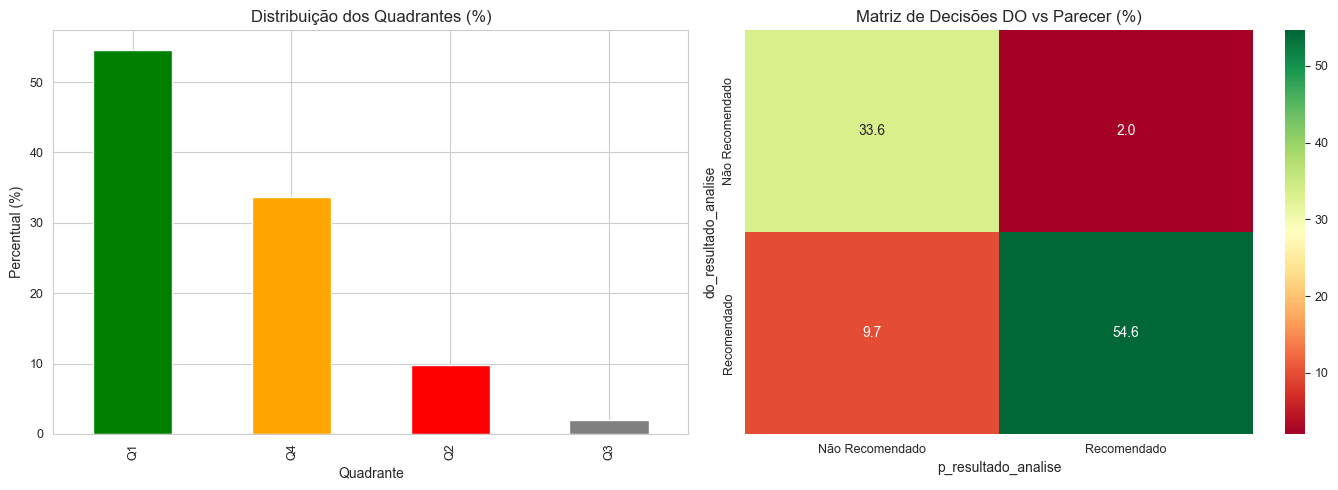

In [12]:
def classificar_quadrante(row):
    """
    Classifica cada projeto em um dos 4 quadrantes baseado nas decisões
    Q1: Ambos recomendam (DO: Sim, Parecer: Sim)
    Q2: DO recomenda, Parecer não (DO: Sim, Parecer: Não) - Ministério mais rigoroso
    Q3: DO não recomenda, Parecer sim (DO: Não, Parecer: Sim) - Pesquisador mais rigoroso
    Q4: Ambos não recomendam (DO: Não, Parecer: Não)
    """
    do_result = row['do_resultado_analise']
    p_result = row['p_resultado_analise']
    
    if pd.isna(do_result) or pd.isna(p_result):
        return np.nan
    
    # Normalizar strings
    do_result = str(do_result).strip().lower()
    p_result = str(p_result).strip().lower()
    
    # Classificar como recomendado ou não
    do_rec = 'recomendado' in do_result and 'não' not in do_result
    p_rec = 'recomendado' in p_result and 'não' not in p_result
    
    if do_rec and p_rec:
        return 'Q1'
    elif do_rec and not p_rec:
        return 'Q2'
    elif not do_rec and p_rec:
        return 'Q3'
    else:
        return 'Q4'

# Aplicar classificação
df['quadrante'] = df.apply(classificar_quadrante, axis=1)

# Filtrar anos relevantes (2018-2023)
df_filtered = df[df['ano_referencia'].isin([2018, 2019, 2020, 2021, 2022, 2023])].copy()
df_filtered = df_filtered.dropna(subset=['quadrante'])

print("="*80)
print("DISTRIBUIÇÃO GERAL DOS QUADRANTES")
print("="*80)
quadrante_dist = df_filtered['quadrante'].value_counts(normalize=True) * 100
print("\nDistribuição percentual dos quadrantes:")
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    if q in quadrante_dist.index:
        print(f"{q}: {quadrante_dist[q]:.1f}%")

# Taxa de concordância e discordância
concordancia = quadrante_dist.get('Q1', 0) + quadrante_dist.get('Q4', 0)
discordancia = quadrante_dist.get('Q2', 0) + quadrante_dist.get('Q3', 0)
print(f"\nTaxa de Concordância Total (Q1+Q4): {concordancia:.1f}%")
print(f"Taxa de Discordância Total (Q2+Q3): {discordancia:.1f}%")

# Visualização
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
quadrante_dist.plot(kind='bar', ax=ax[0], color=['green', 'orange', 'red', 'gray'])
ax[0].set_title('Distribuição dos Quadrantes (%)')
ax[0].set_ylabel('Percentual (%)')
ax[0].set_xlabel('Quadrante')

# Matriz de decisões
matriz_decisoes = pd.crosstab(df_filtered['do_resultado_analise'], 
                              df_filtered['p_resultado_analise'], 
                              normalize='all') * 100
sns.heatmap(matriz_decisoes, annot=True, fmt='.1f', ax=ax[1], cmap='RdYlGn')
ax[1].set_title('Matriz de Decisões DO vs Parecer (%)')
plt.tight_layout()
plt.show()

## 4. Processamento das Justificativas Padronizadas

In [9]:
def processar_justificativa_estruturada(texto):
    """
    Processa justificativa que vem no formato:
    'justificativa_analise / titulo_justificativa / corpo_justificativa / rodape_justificativa / titulo_grupo_objeto'
    
    Retorna um dicionário com os campos processados e indicador se foi recomendado
    """
    if pd.isna(texto):
        return {
            'tem_justificativa': False,
            'recomendado': True,  # Se não tem justificativa, foi recomendado
            'justificativa_resumo': None,
            'justificativa_completa': None,
            'todas_justificativas': []
        }
    
    texto = str(texto)
    
    # Se o campo está vazio ou só tem separadores, foi recomendado
    if texto.strip() in ['', '/', ' / ', ' /  / ', ' /  /  /  / ']:
        return {
            'tem_justificativa': False,
            'recomendado': True,
            'justificativa_resumo': None,
            'justificativa_completa': None,
            'todas_justificativas': []
        }
    
    # Dividir pelos 5 campos usando ' / ' como separador
    partes = texto.split(' / ')
    
    # Garantir que temos 5 partes (pode haver menos se o formato variar)
    while len(partes) < 5:
        partes.append('')
    
    justificativa_analise = partes[0].strip()  # Campo resumido
    titulo_justificativa = partes[1].strip()
    corpo_justificativa = partes[2].strip()    # Campo mais completo
    rodape_justificativa = partes[3].strip()
    titulo_grupo = partes[4].strip()
    
    # Coletar todas as justificativas não vazias
    todas = []
    
    # Processar justificativa_analise (campo resumido) - pode ter múltiplas separadas por ||
    if justificativa_analise and justificativa_analise != '/':
        for just in justificativa_analise.split('||'):
            just = just.strip()
            if just and len(just) > 10:
                todas.append(('resumo', just))
    
    # Processar corpo_justificativa (campo completo) - pode ter múltiplas separadas por ||
    if corpo_justificativa and corpo_justificativa != '/':
        for just in corpo_justificativa.split('||'):
            just = just.strip()
            # Filtrar frases padrão
            if (just and 
                len(just) > 10 and
                'Dessa forma, o projeto apresentado não foi recomendado' not in just and
                'No projeto nº' not in just):
                todas.append(('completo', just))
    
    # Se tem justificativas, não foi recomendado
    tem_justificativa = len(todas) > 0
    
    return {
        'tem_justificativa': tem_justificativa,
        'recomendado': not tem_justificativa,
        'justificativa_resumo': justificativa_analise if justificativa_analise else None,
        'justificativa_completa': corpo_justificativa if corpo_justificativa else None,
        'todas_justificativas': todas
    }

# Processar justificativas DO
print("="*80)
print("PROCESSAMENTO DAS JUSTIFICATIVAS ESTRUTURADAS")
print("="*80)

df_filtered['do_justificativa_processada'] = df_filtered['do_justificativa_padronizada'].apply(processar_justificativa_estruturada)
df_filtered['p_justificativa_processada'] = df_filtered['p_justificativa_padronizada'].apply(processar_justificativa_estruturada)

# Extrair campos processados
df_filtered['do_tem_justificativa'] = df_filtered['do_justificativa_processada'].apply(lambda x: x['tem_justificativa'])
df_filtered['p_tem_justificativa'] = df_filtered['p_justificativa_processada'].apply(lambda x: x['tem_justificativa'])

# Validação: projetos recomendados não devem ter justificativa
print("\nValidação da lógica de justificativas:")
print("-" * 60)

# DO
do_recomendado = df_filtered['do_resultado_analise'].str.contains('Recomendado', case=False, na=False) & \
                 ~df_filtered['do_resultado_analise'].str.contains('Não', case=False, na=False)
do_sem_justificativa = ~df_filtered['do_tem_justificativa']
consistencia_do = (do_recomendado == do_sem_justificativa).mean() * 100
print(f"DO - Consistência (Recomendado = Sem Justificativa): {consistencia_do:.1f}%")

# Parecer
p_recomendado = df_filtered['p_resultado_analise'].str.contains('Recomendado', case=False, na=False) & \
                ~df_filtered['p_resultado_analise'].str.contains('Não', case=False, na=False)
p_sem_justificativa = ~df_filtered['p_tem_justificativa']
consistencia_p = (p_recomendado == p_sem_justificativa).mean() * 100
print(f"Parecer - Consistência (Recomendado = Sem Justificativa): {consistencia_p:.1f}%")

# Análise das justificativas mais comuns
print("\n" + "="*80)
print("ANÁLISE DAS JUSTIFICATIVAS MAIS FREQUENTES")
print("="*80)

# Coletar todas as justificativas (resumo e completo)
todas_just_do = []
todas_just_p = []

for _, row in df_filtered.iterrows():
    # DO
    if row['do_tem_justificativa']:
        for tipo, just in row['do_justificativa_processada']['todas_justificativas']:
            todas_just_do.append((tipo, just))
    
    # Parecer
    if row['p_tem_justificativa']:
        for tipo, just in row['p_justificativa_processada']['todas_justificativas']:
            todas_just_p.append((tipo, just))

# Contar justificativas resumidas DO
just_resumo_do = [just for tipo, just in todas_just_do if tipo == 'resumo']
just_completo_do = [just for tipo, just in todas_just_do if tipo == 'completo']

print(f"\nJustificativas DO encontradas:")
print(f"  - Resumidas: {len(set(just_resumo_do))} únicas ({len(just_resumo_do)} total)")
print(f"  - Completas: {len(set(just_completo_do))} únicas ({len(just_completo_do)} total)")

# Top justificativas resumidas DO
if just_resumo_do:
    print("\nTop 10 Justificativas DO Resumidas mais frequentes:")
    counter_resumo = Counter(just_resumo_do)
    for i, (just, count) in enumerate(counter_resumo.most_common(10), 1):
        pct = count / len(just_resumo_do) * 100
        print(f"\n{i}. [{count}x - {pct:.1f}%]")
        print(f"   {just[:150]}...")

# Contar justificativas resumidas Parecer
just_resumo_p = [just for tipo, just in todas_just_p if tipo == 'resumo']
just_completo_p = [just for tipo, just in todas_just_p if tipo == 'completo']

print(f"\n\nJustificativas Parecer encontradas:")
print(f"  - Resumidas: {len(set(just_resumo_p))} únicas ({len(just_resumo_p)} total)")
print(f"  - Completas: {len(set(just_completo_p))} únicas ({len(just_completo_p)} total)")

# Top justificativas resumidas Parecer
if just_resumo_p:
    print("\nTop 10 Justificativas Parecer Resumidas mais frequentes:")
    counter_resumo_p = Counter(just_resumo_p)
    for i, (just, count) in enumerate(counter_resumo_p.most_common(10), 1):
        pct = count / len(just_resumo_p) * 100
        print(f"\n{i}. [{count}x - {pct:.1f}%]")
        print(f"   {just[:150]}...")

# Análise por quadrante
print("\n" + "="*80)
print("RELAÇÃO JUSTIFICATIVAS x QUADRANTES")
print("="*80)

# Projetos no Q2 (DO recomenda, Parecer não)
df_q2 = df_filtered[df_filtered['quadrante'] == 'Q2']
print(f"\nQuadrante Q2 (DO Sim, Parecer Não) - {len(df_q2)} projetos:")
print(f"  - DO sem justificativa (esperado): {(~df_q2['do_tem_justificativa']).mean() * 100:.1f}%")
print(f"  - Parecer com justificativa (esperado): {df_q2['p_tem_justificativa'].mean() * 100:.1f}%")

# Projetos no Q3 (DO não recomenda, Parecer sim)
df_q3 = df_filtered[df_filtered['quadrante'] == 'Q3']
print(f"\nQuadrante Q3 (DO Não, Parecer Sim) - {len(df_q3)} projetos:")
print(f"  - DO com justificativa (esperado): {df_q3['do_tem_justificativa'].mean() * 100:.1f}%")
print(f"  - Parecer sem justificativa (esperado): {(~df_q3['p_tem_justificativa']).mean() * 100:.1f}%")

PROCESSAMENTO DAS JUSTIFICATIVAS ESTRUTURADAS

Validação da lógica de justificativas:
------------------------------------------------------------
DO - Consistência (Recomendado = Sem Justificativa): 85.9%
Parecer - Consistência (Recomendado = Sem Justificativa): 88.6%

ANÁLISE DAS JUSTIFICATIVAS MAIS FREQUENTES

Justificativas DO encontradas:
  - Resumidas: 24 únicas (26104 total)
  - Completas: 24 únicas (26104 total)

Top 10 Justificativas DO Resumidas mais frequentes:

1. [3954x - 15.1%]
   Falta de Clareza na descrição do elemento tecnologicamente novo ou inovador do projeto...

2. [3784x - 14.5%]
   Falta de Clareza na descrição da barreira ou desafio tecnológico superados no projeto...

3. [3456x - 13.2%]
   Falta de Clareza na descrição da metodologia/ métodos utilizados no projeto...

4. [3158x - 12.1%]
   PROJETOS CONTINUADOS...

5. [1577x - 6.0%]
   Projetos de engenharia...

6. [1496x - 5.7%]
   Caracterizou uma inovação sem ter sido resultado de P&D...

7. [1299x - 5.0%]
 

## 5. Investigação 1: Justificativas por Setor e Quadrante

INVESTIGAÇÃO 1: PADRÕES DE JUSTIFICATIVAS POR SETOR E QUADRANTE

1A. SETOR TIC - QUADRANTE Q2 (Pesquisador Sim, Ministério Não)
------------------------------------------------------------
Projetos TIC no Q2: 945

Justificativas do PARECER para rejeição (enquanto DO aprovou):

1. [13.8% - 916 ocorrências]
   Caracterizou uma inovação sem ter sido resultado de P&D...

2. [13.6% - 903 ocorrências]
   Falta de Clareza na descrição da barreira ou desafio tecnológico superados no projeto...

3. [13.4% - 888 ocorrências]
   Falta de Clareza na descrição do elemento tecnologicamente novo ou inovador do projeto...

4. [11.2% - 743 ocorrências]
   Diferença entre P&D e atividades correlatas (Manual Frascati)...

5. [10.4% - 686 ocorrências]
   Desenvolvimento de Produtos/Processos com tecnologias bem conhecidas, de amplo domínio....

⚠️ Atenção: 303 projetos no Q2 têm justificativa DO (inconsistência)


1B. SETOR MECÂNICA E TRANSPORTE - QUADRANTE Q3 (Pesquisador Não, Ministério Sim)
-----------

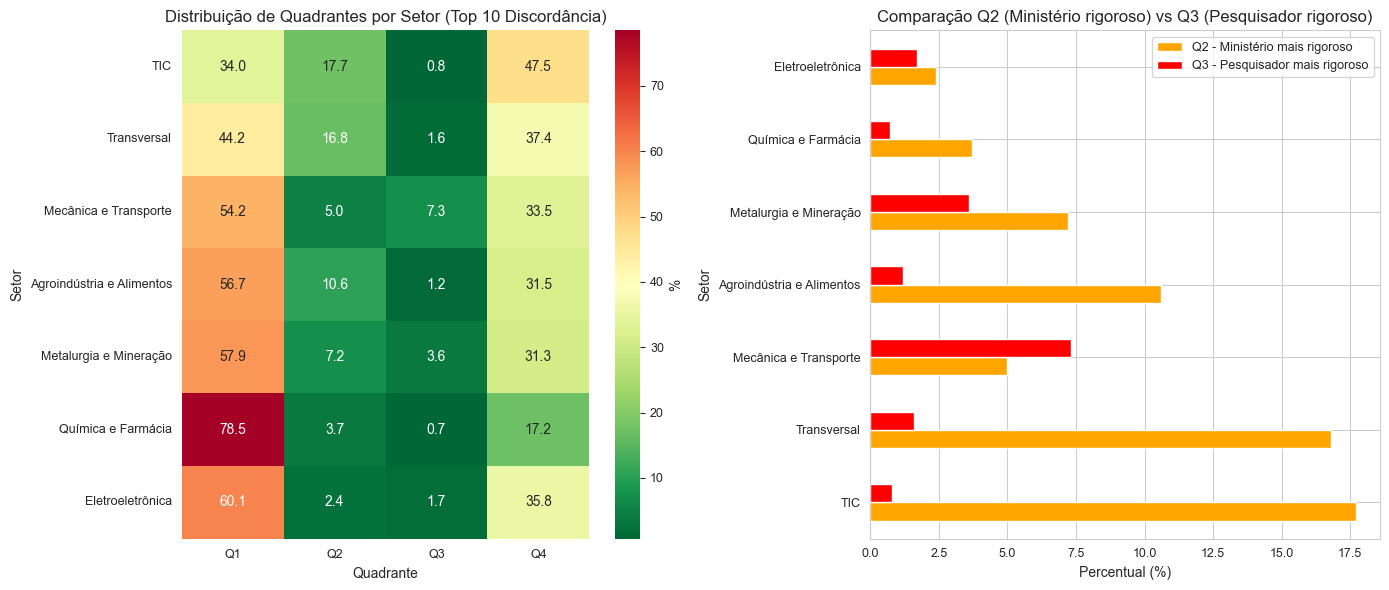


Resumo da Investigação 1:
------------------------------------------------------------
✓ Justificativas do Parecer em Q2 indicam critérios mais rigorosos do Ministério
✓ Justificativas do DO em Q3 mostram onde pesquisadores são mais exigentes
✓ Setores como TIC e Transversal têm padrões distintos de discordância


In [11]:
print("="*80)
print("INVESTIGAÇÃO 1: PADRÕES DE JUSTIFICATIVAS POR SETOR E QUADRANTE")
print("="*80)

# Função para analisar justificativas por setor e quadrante
def analisar_justificativas_setor_quadrante(df, setor, quadrante, tipo='do', nivel='resumo'):
    """
    Analisa as justificativas mais comuns para um setor e quadrante específicos
    tipo: 'do' ou 'p' (parecer)
    nivel: 'resumo' ou 'completo'
    """
    
    df_subset = df[(df['setor'] == setor) & (df['quadrante'] == quadrante)]
    
    if len(df_subset) == 0:
        return None
    
    col_just = f'{tipo}_justificativa_processada'
    todas_just = []
    
    for _, row in df_subset.iterrows():
        if row[f'{tipo}_tem_justificativa']:
            for tipo_just, just in row[col_just]['todas_justificativas']:
                if tipo_just == nivel:
                    todas_just.append(just)
    
    if not todas_just:
        return None
    
    counter = Counter(todas_just)
    total = len(todas_just)
    
    return {
        'n_projetos': len(df_subset),
        'n_justificativas': total,
        'justificativas': [(just, count, count/total*100) for just, count in counter.most_common(5)]
    }

# Análise 1A: TIC no Q2 (Ministério mais rigoroso)
print("\n1A. SETOR TIC - QUADRANTE Q2 (Pesquisador Sim, Ministério Não)")
print("-"*60)

# Para Q2: DO não tem justificativa (recomendou), Parecer tem justificativa (rejeitou)
resultado_tic_q2_parecer = analisar_justificativas_setor_quadrante(df_filtered, 'TIC', 'Q2', 'p', 'resumo')
if resultado_tic_q2_parecer:
    print(f"Projetos TIC no Q2: {resultado_tic_q2_parecer['n_projetos']}")
    print("\nJustificativas do PARECER para rejeição (enquanto DO aprovou):")
    for i, (just, count, pct) in enumerate(resultado_tic_q2_parecer['justificativas'], 1):
        print(f"\n{i}. [{pct:.1f}% - {count} ocorrências]")
        print(f"   {just[:200]}...")

# Verificar se há projetos onde DO tem justificativa no Q2 (não deveria ter)
df_tic_q2 = df_filtered[(df_filtered['setor'] == 'TIC') & (df_filtered['quadrante'] == 'Q2')]
do_com_justificativa_q2 = df_tic_q2['do_tem_justificativa'].sum()
if do_com_justificativa_q2 > 0:
    print(f"\n⚠️ Atenção: {do_com_justificativa_q2} projetos no Q2 têm justificativa DO (inconsistência)")

# Análise 1B: Mecânica e Transporte no Q3 (Pesquisador mais rigoroso)
print("\n\n1B. SETOR MECÂNICA E TRANSPORTE - QUADRANTE Q3 (Pesquisador Não, Ministério Sim)")
print("-"*60)

# Para Q3: DO tem justificativa (rejeitou), Parecer não tem justificativa (aprovou)
resultado_mec_q3_do = analisar_justificativas_setor_quadrante(df_filtered, 'Mecânica e Transporte', 'Q3', 'do', 'resumo')
if resultado_mec_q3_do:
    print(f"Projetos Mecânica e Transporte no Q3: {resultado_mec_q3_do['n_projetos']}")
    print("\nJustificativas DO para rejeição (mas Ministério aprovou):")
    for i, (just, count, pct) in enumerate(resultado_mec_q3_do['justificativas'], 1):
        print(f"\n{i}. [{pct:.1f}% - {count} ocorrências]")
        print(f"   {just[:200]}...")

# Verificar se há projetos onde Parecer tem justificativa no Q3 (não deveria ter)
df_mec_q3 = df_filtered[(df_filtered['setor'] == 'Mecânica e Transporte') & (df_filtered['quadrante'] == 'Q3')]
p_com_justificativa_q3 = df_mec_q3['p_tem_justificativa'].sum()
if p_com_justificativa_q3 > 0:
    print(f"\n⚠️ Atenção: {p_com_justificativa_q3} projetos no Q3 têm justificativa Parecer (inconsistência)")

# Análise 1C: Comparação entre setores
print("\n\n1C. ANÁLISE DETALHADA DE JUSTIFICATIVAS POR SETOR")
print("-"*60)

# Criar análise consolidada por setor e quadrante
analise_justificativas = []

for setor in df_filtered['setor'].unique():
    for quadrante in ['Q1', 'Q2', 'Q3', 'Q4']:
        df_sq = df_filtered[(df_filtered['setor'] == setor) & (df_filtered['quadrante'] == quadrante)]
        
        if len(df_sq) >= 5:  # Só analisar se tem pelo menos 5 projetos
            # Contar justificativas
            n_do_just = df_sq['do_tem_justificativa'].sum()
            n_p_just = df_sq['p_tem_justificativa'].sum()
            total = len(df_sq)
            
            analise_justificativas.append({
                'Setor': setor,
                'Quadrante': quadrante,
                'N_Projetos': total,
                'DO_com_just_%': n_do_just/total*100,
                'Parecer_com_just_%': n_p_just/total*100
            })

df_analise = pd.DataFrame(analise_justificativas)

# Mostrar setores com maior discordância
print("\nSetores com maior taxa em Q2 (Ministério mais rigoroso):")
q2_analysis = df_analise[df_analise['Quadrante'] == 'Q2'].sort_values('N_Projetos', ascending=False).head(5)
for _, row in q2_analysis.iterrows():
    print(f"{row['Setor']:30} - {row['N_Projetos']:3} projetos "
          f"(Parecer c/ just: {row['Parecer_com_just_%']:.0f}%)")

print("\nSetores com maior taxa em Q3 (Pesquisador mais rigoroso):")
q3_analysis = df_analise[df_analise['Quadrante'] == 'Q3'].sort_values('N_Projetos', ascending=False).head(5)
for _, row in q3_analysis.iterrows():
    print(f"{row['Setor']:30} - {row['N_Projetos']:3} projetos "
          f"(DO c/ just: {row['DO_com_just_%']:.0f}%)")

# Análise de justificativas mais discriminantes
print("\n\n1D. JUSTIFICATIVAS MAIS DISCRIMINANTES")
print("-"*60)

# Encontrar justificativas que aparecem muito em Q2 ou Q3
justificativas_discriminantes_q2 = []
justificativas_discriminantes_q3 = []

# Para Q2: justificativas do Parecer que levam à rejeição
df_q2_all = df_filtered[df_filtered['quadrante'] == 'Q2']
for _, row in df_q2_all.iterrows():
    if row['p_tem_justificativa']:
        for tipo, just in row['p_justificativa_processada']['todas_justificativas']:
            if tipo == 'resumo':
                justificativas_discriminantes_q2.append(just)

# Para Q3: justificativas do DO que levam à rejeição
df_q3_all = df_filtered[df_filtered['quadrante'] == 'Q3']
for _, row in df_q3_all.iterrows():
    if row['do_tem_justificativa']:
        for tipo, just in row['do_justificativa_processada']['todas_justificativas']:
            if tipo == 'resumo':
                justificativas_discriminantes_q3.append(just)

if justificativas_discriminantes_q2:
    print("\nTop 5 justificativas do PARECER que levam ao Q2:")
    counter_q2 = Counter(justificativas_discriminantes_q2)
    for i, (just, count) in enumerate(counter_q2.most_common(5), 1):
        pct = count / len(justificativas_discriminantes_q2) * 100
        print(f"\n{i}. [{count}x - {pct:.1f}%]")
        print(f"   {just[:150]}...")

if justificativas_discriminantes_q3:
    print("\nTop 5 justificativas do DO que levam ao Q3:")
    counter_q3 = Counter(justificativas_discriminantes_q3)
    for i, (just, count) in enumerate(counter_q3.most_common(5), 1):
        pct = count / len(justificativas_discriminantes_q3) * 100
        print(f"\n{i}. [{count}x - {pct:.1f}%]")
        print(f"   {just[:150]}...")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Distribuição de quadrantes por setor
quadrante_setor = pd.crosstab(df_filtered['setor'], df_filtered['quadrante'], normalize='index') * 100
quadrante_setor = quadrante_setor.round(1)

# Destacar setores com maior discordância
quadrante_setor['Discordância_Total'] = quadrante_setor.get('Q2', 0) + quadrante_setor.get('Q3', 0)
quadrante_setor_sorted = quadrante_setor.sort_values('Discordância_Total', ascending=False)

# Plotar heatmap
sns.heatmap(quadrante_setor_sorted[['Q1', 'Q2', 'Q3', 'Q4']].head(10), 
            annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[0], cbar_kws={'label': '%'})
axes[0].set_title('Distribuição de Quadrantes por Setor (Top 10 Discordância)')
axes[0].set_xlabel('Quadrante')
axes[0].set_ylabel('Setor')

# Gráfico 2: Comparação Q2 vs Q3 por setor
setores_top = quadrante_setor_sorted.head(7).index
q2_q3_data = quadrante_setor.loc[setores_top, ['Q2', 'Q3']]
q2_q3_data.plot(kind='barh', ax=axes[1], color=['orange', 'red'])
axes[1].set_title('Comparação Q2 (Ministério rigoroso) vs Q3 (Pesquisador rigoroso)')
axes[1].set_xlabel('Percentual (%)')
axes[1].set_ylabel('Setor')
axes[1].legend(['Q2 - Ministério mais rigoroso', 'Q3 - Pesquisador mais rigoroso'])

plt.tight_layout()
plt.show()

print("\nResumo da Investigação 1:")
print("-" * 60)
print("✓ Justificativas do Parecer em Q2 indicam critérios mais rigorosos do Ministério")
print("✓ Justificativas do DO em Q3 mostram onde pesquisadores são mais exigentes")
print("✓ Setores como TIC e Transversal têm padrões distintos de discordância")

## 6. Investigação 2: Análise da Anomalia de 2021

INVESTIGAÇÃO 2: ANOMALIA DE 2021 - PICO DE DISCORDÂNCIA

Evolução dos Quadrantes por Ano (%):
quadrante         Q1    Q2   Q3    Q4
ano_referencia                       
2020.0          62.9   1.3  4.6  31.2
2021.0          49.6  16.0  2.0  32.3
2022.0          51.9  14.7  0.6  32.7
2023.0          55.8   0.0  0.0  44.2


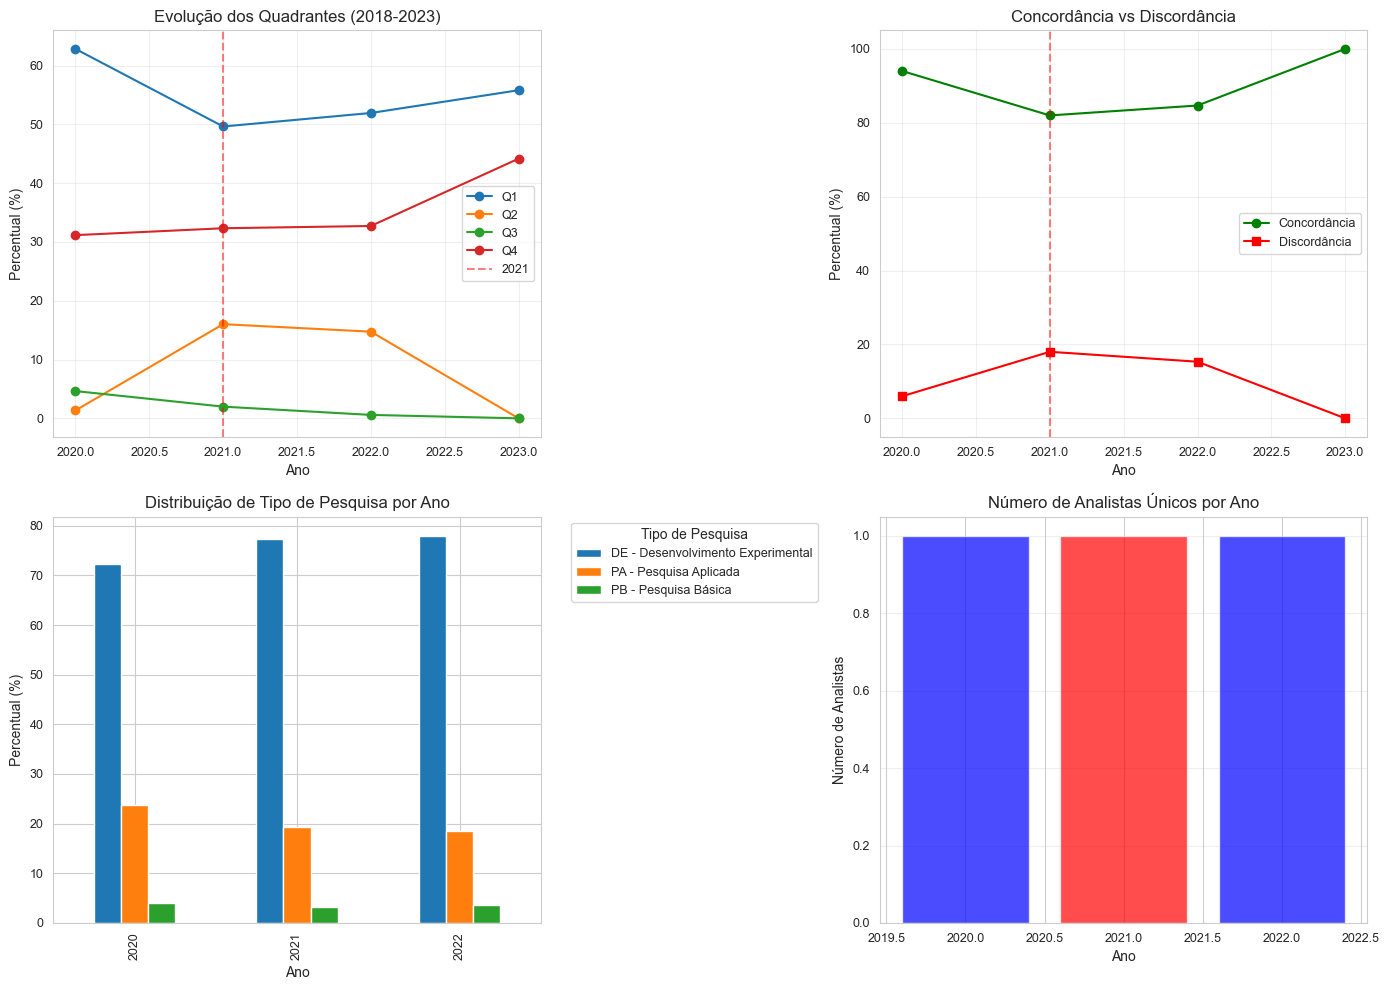


ANÁLISE DETALHADA DE 2021

Mudança no perfil de Tipo de Pesquisa (2020 → 2021 → 2022):
DE - Desenvolvimento Experimental        2020→2021: +5.1%  |  2021→2022: +0.5%
PA - Pesquisa Aplicada                   2020→2021: -4.4%  |  2021→2022: -0.8%
PB - Pesquisa Básica                     2020→2021: -0.7%  |  2021→2022: +0.3%


Analistas com maior % de projetos no Q2 em 2021 (Top 10):
(Q2 = Pesquisador recomenda, Ministério rejeita)
 1. Analista 300905151.0: 15.9% no Q2 (n=7102 projetos)


In [6]:
print("="*80)
print("INVESTIGAÇÃO 2: ANOMALIA DE 2021 - PICO DE DISCORDÂNCIA")
print("="*80)

# Evolução temporal dos quadrantes
quadrante_ano = pd.crosstab(df_filtered['ano_referencia'], df_filtered['quadrante'], normalize='index') * 100

print("\nEvolução dos Quadrantes por Ano (%):")
print(quadrante_ano.round(1))

# Visualização da evolução
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Evolução dos quadrantes
quadrante_ano.plot(kind='line', marker='o', ax=axes[0,0])
axes[0,0].set_title('Evolução dos Quadrantes (2018-2023)')
axes[0,0].set_xlabel('Ano')
axes[0,0].set_ylabel('Percentual (%)')
axes[0,0].axvline(x=2021, color='red', linestyle='--', alpha=0.5, label='2021')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Taxa de concordância vs discordância
concordancia_ano = quadrante_ano[['Q1', 'Q4']].sum(axis=1)
discordancia_ano = quadrante_ano[['Q2', 'Q3']].sum(axis=1)
axes[0,1].plot(concordancia_ano.index, concordancia_ano.values, marker='o', label='Concordância', color='green')
axes[0,1].plot(discordancia_ano.index, discordancia_ano.values, marker='s', label='Discordância', color='red')
axes[0,1].set_title('Concordância vs Discordância')
axes[0,1].set_xlabel('Ano')
axes[0,1].set_ylabel('Percentual (%)')
axes[0,1].axvline(x=2021, color='red', linestyle='--', alpha=0.5)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Análise de tipo_pesquisa por ano
tipo_pesquisa_2020 = df_filtered[df_filtered['ano_referencia'] == 2020]['tipo_pesquisa'].value_counts(normalize=True)
tipo_pesquisa_2021 = df_filtered[df_filtered['ano_referencia'] == 2021]['tipo_pesquisa'].value_counts(normalize=True)
tipo_pesquisa_2022 = df_filtered[df_filtered['ano_referencia'] == 2022]['tipo_pesquisa'].value_counts(normalize=True)

# Gráfico 3: Mudança no tipo de pesquisa
tipos_df = pd.DataFrame({
    '2020': tipo_pesquisa_2020,
    '2021': tipo_pesquisa_2021,
    '2022': tipo_pesquisa_2022
}).fillna(0) * 100

tipos_df.T.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Distribuição de Tipo de Pesquisa por Ano')
axes[1,0].set_xlabel('Ano')
axes[1,0].set_ylabel('Percentual (%)')
axes[1,0].legend(title='Tipo de Pesquisa', bbox_to_anchor=(1.05, 1), loc='upper left')

# Análise de analistas
analistas_2020 = df_filtered[df_filtered['ano_referencia'] == 2020]['p_id_analista_mcti'].nunique()
analistas_2021 = df_filtered[df_filtered['ano_referencia'] == 2021]['p_id_analista_mcti'].nunique()
analistas_2022 = df_filtered[df_filtered['ano_referencia'] == 2022]['p_id_analista_mcti'].nunique()

# Gráfico 4: Número de analistas únicos
anos = [2020, 2021, 2022]
n_analistas = [analistas_2020, analistas_2021, analistas_2022]
axes[1,1].bar(anos, n_analistas, color=['blue', 'red', 'blue'], alpha=0.7)
axes[1,1].set_title('Número de Analistas Únicos por Ano')
axes[1,1].set_xlabel('Ano')
axes[1,1].set_ylabel('Número de Analistas')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Análise detalhada de 2021
print("\n" + "="*60)
print("ANÁLISE DETALHADA DE 2021")
print("="*60)

# Mudanças em tipo_pesquisa
print("\nMudança no perfil de Tipo de Pesquisa (2020 → 2021 → 2022):")
for tipo in tipos_df.index:
    delta_2021 = tipos_df.loc[tipo, '2021'] - tipos_df.loc[tipo, '2020']
    delta_2022 = tipos_df.loc[tipo, '2022'] - tipos_df.loc[tipo, '2021']
    print(f"{tipo:40} 2020→2021: {delta_2021:+.1f}%  |  2021→2022: {delta_2022:+.1f}%")

# Analistas mais rigorosos em 2021
df_2021 = df_filtered[df_filtered['ano_referencia'] == 2021]
analista_rigor = df_2021.groupby('p_id_analista_mcti').agg({
    'quadrante': lambda x: (x == 'Q2').mean() * 100  # % de projetos no Q2
}).sort_values('quadrante', ascending=False)

print(f"\n\nAnalistas com maior % de projetos no Q2 em 2021 (Top 10):")
print("(Q2 = Pesquisador recomenda, Ministério rejeita)")
for i, (analista, pct) in enumerate(analista_rigor.head(10).itertuples(), 1):
    n_projetos = len(df_2021[df_2021['p_id_analista_mcti'] == analista])
    print(f"{i:2}. Analista {analista}: {pct:.1f}% no Q2 (n={n_projetos} projetos)")

## 7. Investigação 3: O Caso Química e Farmácia

INVESTIGAÇÃO 3: QUÍMICA E FARMÁCIA - OUTLIER DE CONCORDÂNCIA

Estatísticas por Setor (ordenado por concordância):
                           Similaridade_Média  Similaridade_Std  \
setor                                                             
Eletroeletrônica                         0.93              0.07   
Química e Farmácia                       0.94              0.07   
Metalurgia e Mineração                   0.92              0.07   
Agroindústria e Alimentos                0.92              0.07   
Mecânica e Transporte                    0.94              0.07   
Transversal                              0.90              0.07   
TIC                                      0.92              0.07   

                           Similaridade_Mediana  Taxa_Concordância  N_Projetos  
setor                                                                           
Eletroeletrônica                           1.00              95.90        2291  
Química e Farmácia                     

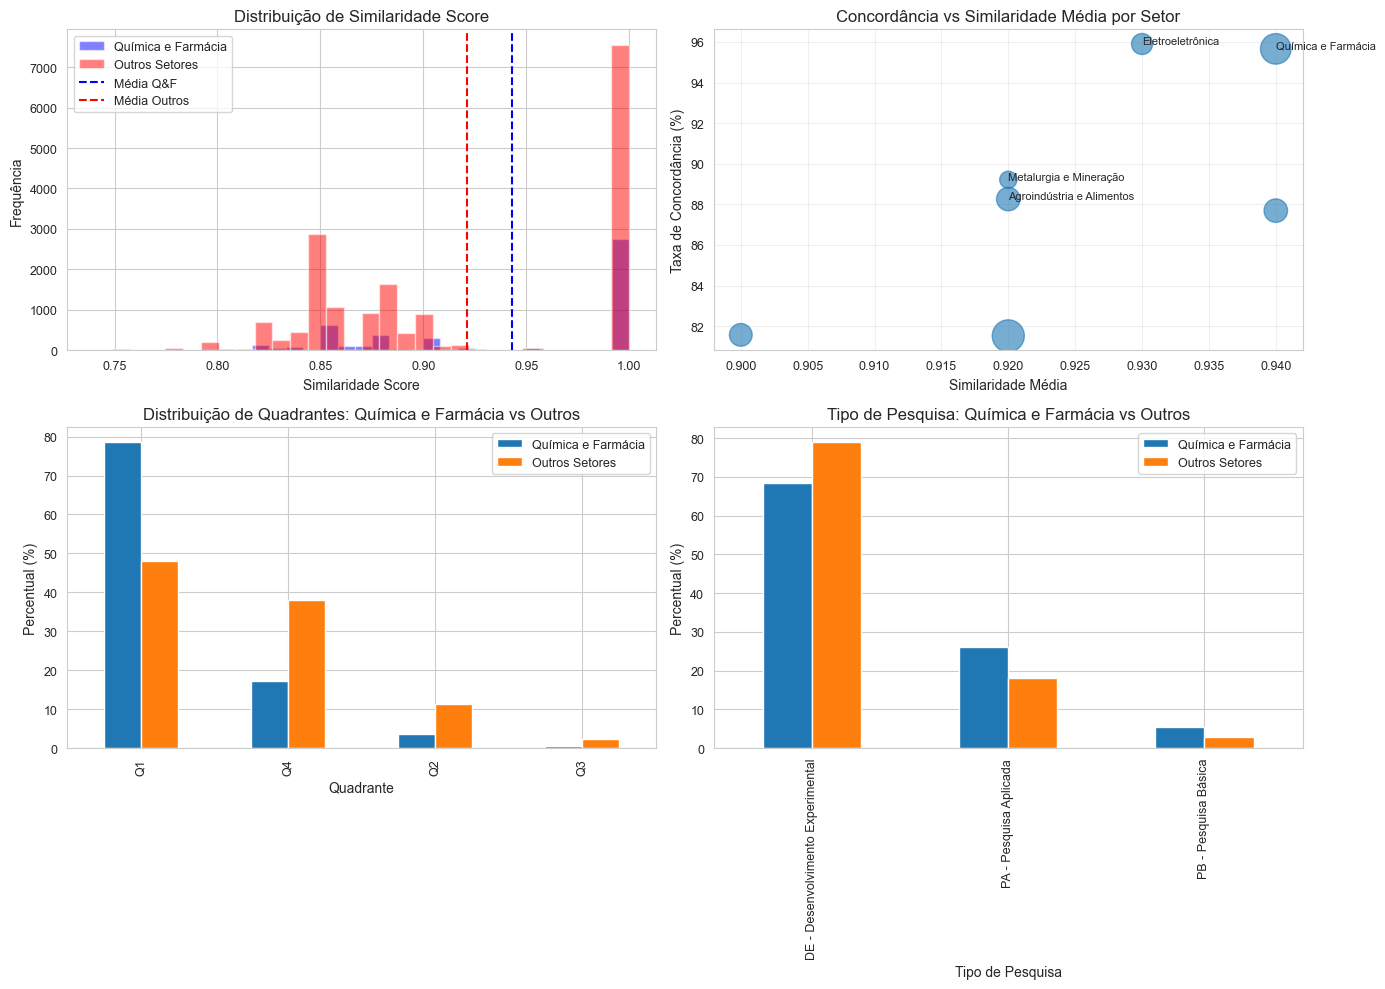


TESTE ESTATÍSTICO
Teste t para diferença de similaridade:
  t-statistic: 19.0885
  p-value: 0.0000
  → Diferença estatisticamente significativa (p < 0.05)


In [7]:
print("="*80)
print("INVESTIGAÇÃO 3: QUÍMICA E FARMÁCIA - OUTLIER DE CONCORDÂNCIA")
print("="*80)

# Estatísticas por setor
estatisticas_setor = df_filtered.groupby('setor').agg({
    'similaridade_score': ['mean', 'std', 'median'],
    'quadrante': lambda x: ((x == 'Q1').sum() + (x == 'Q4').sum()) / len(x) * 100,  # Taxa de concordância
    'projeto_id': 'count'
}).round(2)

estatisticas_setor.columns = ['Similaridade_Média', 'Similaridade_Std', 'Similaridade_Mediana', 
                              'Taxa_Concordância', 'N_Projetos']
estatisticas_setor = estatisticas_setor.sort_values('Taxa_Concordância', ascending=False)

print("\nEstatísticas por Setor (ordenado por concordância):")
print(estatisticas_setor.head(10))

# Comparação Química e Farmácia vs outros
df_quimica = df_filtered[df_filtered['setor'] == 'Química e Farmácia']
df_outros = df_filtered[df_filtered['setor'] != 'Química e Farmácia']

print("\n" + "="*60)
print("COMPARAÇÃO: QUÍMICA E FARMÁCIA vs OUTROS SETORES")
print("="*60)

# Similaridade
print(f"\nSimilaridade Score:")
print(f"  Química e Farmácia: {df_quimica['similaridade_score'].mean():.3f} (±{df_quimica['similaridade_score'].std():.3f})")
print(f"  Outros Setores:     {df_outros['similaridade_score'].mean():.3f} (±{df_outros['similaridade_score'].std():.3f})")

# Distribuição por tipo_pesquisa
print(f"\nDistribuição por Tipo de Pesquisa (%):")
tipo_quimica = df_quimica['tipo_pesquisa'].value_counts(normalize=True) * 100
tipo_outros = df_outros['tipo_pesquisa'].value_counts(normalize=True) * 100

comparacao_tipo = pd.DataFrame({
    'Química e Farmácia': tipo_quimica,
    'Outros Setores': tipo_outros
}).fillna(0).round(1)
print(comparacao_tipo)

# Distribuição por natureza
print(f"\nDistribuição por Natureza (%):")
nat_quimica = df_quimica['natureza'].value_counts(normalize=True) * 100
nat_outros = df_outros['natureza'].value_counts(normalize=True) * 100

comparacao_nat = pd.DataFrame({
    'Química e Farmácia': nat_quimica,
    'Outros Setores': nat_outros
}).fillna(0).round(1)
print(comparacao_nat)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Distribuição de similaridade
axes[0,0].hist(df_quimica['similaridade_score'].dropna(), bins=30, alpha=0.5, label='Química e Farmácia', color='blue')
axes[0,0].hist(df_outros['similaridade_score'].dropna(), bins=30, alpha=0.5, label='Outros Setores', color='red')
axes[0,0].axvline(df_quimica['similaridade_score'].mean(), color='blue', linestyle='--', label='Média Q&F')
axes[0,0].axvline(df_outros['similaridade_score'].mean(), color='red', linestyle='--', label='Média Outros')
axes[0,0].set_title('Distribuição de Similaridade Score')
axes[0,0].set_xlabel('Similaridade Score')
axes[0,0].set_ylabel('Frequência')
axes[0,0].legend()

# Gráfico 2: Taxa de concordância vs similaridade média
axes[0,1].scatter(estatisticas_setor['Similaridade_Média'], 
                  estatisticas_setor['Taxa_Concordância'],
                  s=estatisticas_setor['N_Projetos']/10,
                  alpha=0.6)
for idx, row in estatisticas_setor.iterrows():
    if idx == 'Química e Farmácia' or row['Taxa_Concordância'] > 88 or row['Taxa_Concordância'] < 75:
        axes[0,1].annotate(idx, (row['Similaridade_Média'], row['Taxa_Concordância']), fontsize=8)
axes[0,1].set_title('Concordância vs Similaridade Média por Setor')
axes[0,1].set_xlabel('Similaridade Média')
axes[0,1].set_ylabel('Taxa de Concordância (%)')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Distribuição de quadrantes - Química vs Outros
quad_quimica = df_quimica['quadrante'].value_counts(normalize=True) * 100
quad_outros = df_outros['quadrante'].value_counts(normalize=True) * 100
comparacao_quad = pd.DataFrame({
    'Química e Farmácia': quad_quimica,
    'Outros Setores': quad_outros
}).fillna(0)
comparacao_quad.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Distribuição de Quadrantes: Química e Farmácia vs Outros')
axes[1,0].set_xlabel('Quadrante')
axes[1,0].set_ylabel('Percentual (%)')
axes[1,0].legend()

# Gráfico 4: Tipo de pesquisa comparison
comparacao_tipo.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Tipo de Pesquisa: Química e Farmácia vs Outros')
axes[1,1].set_xlabel('Tipo de Pesquisa')
axes[1,1].set_ylabel('Percentual (%)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Teste estatístico
from scipy import stats
print("\n" + "="*60)
print("TESTE ESTATÍSTICO")
print("="*60)
t_stat, p_value = stats.ttest_ind(df_quimica['similaridade_score'].dropna(), 
                                  df_outros['similaridade_score'].dropna())
print(f"Teste t para diferença de similaridade:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
if p_value < 0.05:
    print("  → Diferença estatisticamente significativa (p < 0.05)")
else:
    print("  → Diferença NÃO é estatisticamente significativa (p >= 0.05)")

## 8. Investigação 4: Similaridade e Reversões de Decisão

INVESTIGAÇÃO 4: IMPACTO DA SIMILARIDADE NAS REVERSÕES DE DECISÃO

Estatísticas de Similaridade por Quadrante:
            mean    std  median  count
quadrante                             
Q1         0.932  0.071    1.00  12244
Q2         0.918  0.071    0.88   2184
Q3         0.929  0.074    0.95    457
Q4         0.917  0.072    0.89   7538

DISTRIBUIÇÃO DE QUADRANTES POR CATEGORIA DE SIMILARIDADE (%)
quadrante                 Q1   Q2   Q3    Q4
similaridade_categoria                      
Média                   32.4  2.9  2.9  61.8
Alta                    54.6  9.8  2.0  33.6

TAXAS DE CONCORDÂNCIA/DISCORDÂNCIA POR SIMILARIDADE
Similaridade Média        - Concordância: 94.1% | Discordância: 5.9%
Similaridade Alta         - Concordância: 88.2% | Discordância: 11.8%

ANÁLISE DE SIMILARIDADE E REVERSÕES POR SETOR

TIC:
  Similaridade média Q1 (ambos aprovam):    0.921
  Similaridade média Q2 (Ministério rigoroso): 0.916
  Similaridade média Q3 (Pesquisador rigoroso): 0.934
  Similarida

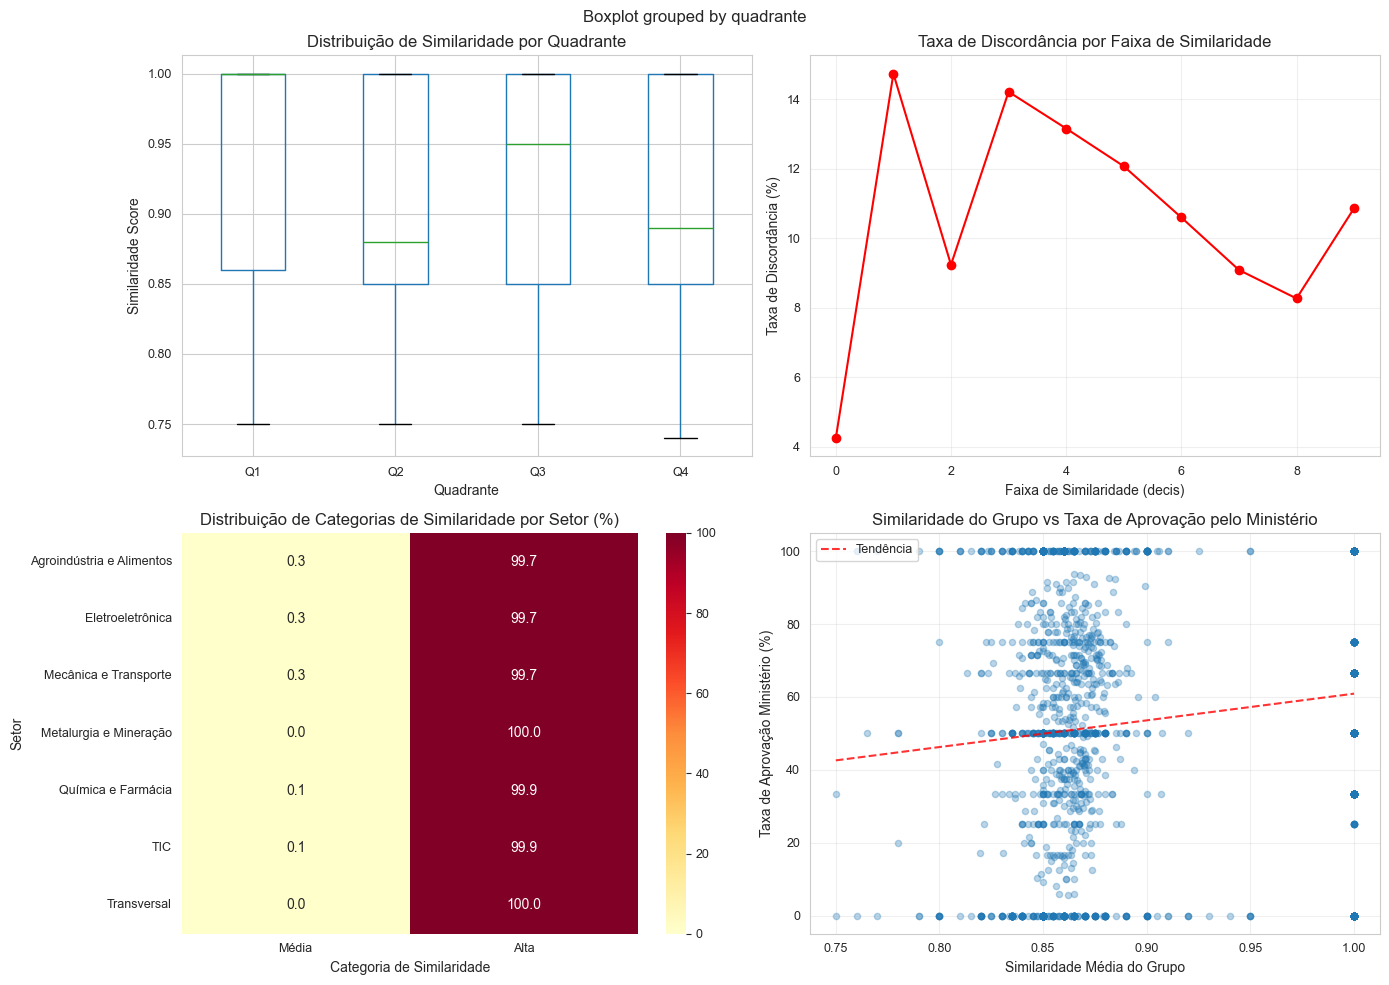


IDENTIFICAÇÃO DE LIMIARES CRÍTICOS DE SIMILARIDADE

Ponto de máxima discordância: similaridade ≈ 0.840
  Taxa de discordância neste ponto: 21.0%

Ponto de mínima discordância: similaridade ≈ 1.000
  Taxa de discordância neste ponto: 3.0%


In [8]:
print("="*80)
print("INVESTIGAÇÃO 4: IMPACTO DA SIMILARIDADE NAS REVERSÕES DE DECISÃO")
print("="*80)

# Análise de similaridade por quadrante
similaridade_quadrante = df_filtered.groupby('quadrante')['similaridade_score'].agg(['mean', 'std', 'median', 'count'])
print("\nEstatísticas de Similaridade por Quadrante:")
print(similaridade_quadrante.round(3))

# Criar categorias de similaridade
df_filtered['similaridade_categoria'] = pd.cut(df_filtered['similaridade_score'], 
                                                bins=[0, 0.25, 0.5, 0.75, 1.0],
                                                labels=['Muito Baixa', 'Baixa', 'Média', 'Alta'])

# Distribuição de quadrantes por categoria de similaridade
quadrante_sim_cat = pd.crosstab(df_filtered['similaridade_categoria'], 
                                df_filtered['quadrante'], 
                                normalize='index') * 100

print("\n" + "="*60)
print("DISTRIBUIÇÃO DE QUADRANTES POR CATEGORIA DE SIMILARIDADE (%)")
print("="*60)
print(quadrante_sim_cat.round(1))

# Taxa de discordância por categoria de similaridade
quadrante_sim_cat['Taxa_Discordância'] = quadrante_sim_cat['Q2'] + quadrante_sim_cat['Q3']
quadrante_sim_cat['Taxa_Concordância'] = quadrante_sim_cat['Q1'] + quadrante_sim_cat['Q4']

print("\n" + "="*60)
print("TAXAS DE CONCORDÂNCIA/DISCORDÂNCIA POR SIMILARIDADE")
print("="*60)
for cat in quadrante_sim_cat.index:
    disc = quadrante_sim_cat.loc[cat, 'Taxa_Discordância']
    conc = quadrante_sim_cat.loc[cat, 'Taxa_Concordância']
    print(f"Similaridade {cat:12} - Concordância: {conc:.1f}% | Discordância: {disc:.1f}%")

# Análise específica por setor
setores_principais = ['TIC', 'Mecânica e Transporte', 'Química e Farmácia', 'Eletroeletrônica']

print("\n" + "="*60)
print("ANÁLISE DE SIMILARIDADE E REVERSÕES POR SETOR")
print("="*60)

for setor in setores_principais:
    df_setor = df_filtered[df_filtered['setor'] == setor]
    if len(df_setor) > 0:
        # Correlação entre similaridade e tipo de quadrante
        df_setor_q2 = df_setor[df_setor['quadrante'] == 'Q2']['similaridade_score'].mean()
        df_setor_q3 = df_setor[df_setor['quadrante'] == 'Q3']['similaridade_score'].mean()
        df_setor_q1 = df_setor[df_setor['quadrante'] == 'Q1']['similaridade_score'].mean()
        df_setor_q4 = df_setor[df_setor['quadrante'] == 'Q4']['similaridade_score'].mean()
        
        print(f"\n{setor}:")
        print(f"  Similaridade média Q1 (ambos aprovam):    {df_setor_q1:.3f}")
        print(f"  Similaridade média Q2 (Ministério rigoroso): {df_setor_q2:.3f}")
        print(f"  Similaridade média Q3 (Pesquisador rigoroso): {df_setor_q3:.3f}")
        print(f"  Similaridade média Q4 (ambos rejeitam):   {df_setor_q4:.3f}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Boxplot de similaridade por quadrante
df_filtered.boxplot(column='similaridade_score', by='quadrante', ax=axes[0,0])
axes[0,0].set_title('Distribuição de Similaridade por Quadrante')
axes[0,0].set_xlabel('Quadrante')
axes[0,0].set_ylabel('Similaridade Score')
plt.sca(axes[0,0])
plt.xticks(rotation=0)

# Gráfico 2: Taxa de discordância vs similaridade
sim_bins = pd.cut(df_filtered['similaridade_score'], bins=10)
disc_by_sim = df_filtered.groupby(sim_bins).apply(
    lambda x: ((x['quadrante'] == 'Q2') | (x['quadrante'] == 'Q3')).mean() * 100
)
axes[0,1].plot(range(len(disc_by_sim)), disc_by_sim.values, marker='o', color='red')
axes[0,1].set_title('Taxa de Discordância por Faixa de Similaridade')
axes[0,1].set_xlabel('Faixa de Similaridade (decis)')
axes[0,1].set_ylabel('Taxa de Discordância (%)')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Heatmap setor vs categoria de similaridade
setor_sim_cat = pd.crosstab(df_filtered['setor'], df_filtered['similaridade_categoria'])
setor_sim_cat_norm = setor_sim_cat.div(setor_sim_cat.sum(axis=1), axis=0) * 100
sns.heatmap(setor_sim_cat_norm, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,0])
axes[1,0].set_title('Distribuição de Categorias de Similaridade por Setor (%)')
axes[1,0].set_xlabel('Categoria de Similaridade')
axes[1,0].set_ylabel('Setor')

# Gráfico 4: Scatter plot similaridade vs taxa de aprovação
df_projetos_grupo = df_filtered.groupby('grupo_id_final').agg({
    'similaridade_score': 'mean',
    'quadrante': lambda x: ((x == 'Q1') | (x == 'Q3')).mean() * 100  # Taxa de aprovação pelo Ministério
})
axes[1,1].scatter(df_projetos_grupo['similaridade_score'], 
                  df_projetos_grupo['quadrante'],
                  alpha=0.3, s=20)
axes[1,1].set_title('Similaridade do Grupo vs Taxa de Aprovação pelo Ministério')
axes[1,1].set_xlabel('Similaridade Média do Grupo')
axes[1,1].set_ylabel('Taxa de Aprovação Ministério (%)')
axes[1,1].grid(True, alpha=0.3)

# Adicionar linha de tendência
z = np.polyfit(df_projetos_grupo['similaridade_score'].dropna(), 
               df_projetos_grupo['quadrante'].dropna(), 1)
p = np.poly1d(z)
x_trend = np.linspace(df_projetos_grupo['similaridade_score'].min(), 
                      df_projetos_grupo['similaridade_score'].max(), 100)
axes[1,1].plot(x_trend, p(x_trend), "r--", alpha=0.8, label=f'Tendência')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Identificar limiares críticos
print("\n" + "="*60)
print("IDENTIFICAÇÃO DE LIMIARES CRÍTICOS DE SIMILARIDADE")
print("="*60)

# Encontrar o ponto de inflexão
similaridade_sorted = df_filtered.sort_values('similaridade_score')
window_size = 100
discordancia_rolling = []
similaridade_points = []

for i in range(window_size, len(similaridade_sorted) - window_size):
    window = similaridade_sorted.iloc[i-window_size:i+window_size]
    disc_rate = ((window['quadrante'] == 'Q2') | (window['quadrante'] == 'Q3')).mean()
    discordancia_rolling.append(disc_rate)
    similaridade_points.append(window['similaridade_score'].mean())

# Encontrar mudanças significativas
if discordancia_rolling:
    max_disc_idx = np.argmax(discordancia_rolling)
    min_disc_idx = np.argmin(discordancia_rolling)
    
    print(f"\nPonto de máxima discordância: similaridade ≈ {similaridade_points[max_disc_idx]:.3f}")
    print(f"  Taxa de discordância neste ponto: {discordancia_rolling[max_disc_idx]*100:.1f}%")
    
    print(f"\nPonto de mínima discordância: similaridade ≈ {similaridade_points[min_disc_idx]:.3f}")
    print(f"  Taxa de discordância neste ponto: {discordancia_rolling[min_disc_idx]*100:.1f}%")

## 9. Análise de Grupos e Padrões Adicionais

In [ ]:
print("="*80)
print("ANÁLISE ADICIONAL: PADRÕES POR GRUPOS E ORIGEM DE AGRUPAMENTO")
print("="*80)

# Análise por origem_agrupamento
if 'origem_agrupamento' in df_filtered.columns:
    origem_quadrante = pd.crosstab(df_filtered['origem_agrupamento'], 
                                   df_filtered['quadrante'], 
                                   normalize='index') * 100
    print("\nDistribuição de Quadrantes por Origem de Agrupamento (%):")
    print(origem_quadrante.round(1))

# Análise de grupos com alta/baixa concordância
grupos_stats = df_filtered.groupby('grupo_id_final').agg({
    'quadrante': [
        lambda x: len(x),  # tamanho do grupo
        lambda x: ((x == 'Q1') | (x == 'Q4')).mean() * 100,  # taxa de concordância
        lambda x: (x == 'Q1').mean() * 100,  # taxa Q1
        lambda x: (x == 'Q2').mean() * 100,  # taxa Q2
        lambda x: (x == 'Q3').mean() * 100,  # taxa Q3
        lambda x: (x == 'Q4').mean() * 100,  # taxa Q4
    ],
    'similaridade_score': 'mean',
    'setor': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Diversos'
})

grupos_stats.columns = ['Tamanho', 'Taxa_Concordância', 'Taxa_Q1', 'Taxa_Q2', 'Taxa_Q3', 'Taxa_Q4', 'Similaridade_Média', 'Setor_Principal']

# Filtrar grupos com pelo menos 5 projetos
grupos_relevantes = grupos_stats[grupos_stats['Tamanho'] >= 5].copy()

print(f"\n" + "="*60)
print(f"GRUPOS COM PADRÕES EXTREMOS (mínimo 5 projetos)")
print(f"="*60)

print("\nTop 10 Grupos com MAIOR Concordância:")
top_concordancia = grupos_relevantes.sort_values('Taxa_Concordância', ascending=False).head(10)
for i, (grupo_id, row) in enumerate(top_concordancia.iterrows(), 1):
    print(f"{i:2}. Grupo {grupo_id}: {row['Taxa_Concordância']:.1f}% concordância "
          f"(n={int(row['Tamanho'])}, Setor: {row['Setor_Principal']}, Sim: {row['Similaridade_Média']:.3f})")

print("\nTop 10 Grupos com MAIOR Discordância:")
grupos_relevantes['Taxa_Discordância'] = grupos_relevantes['Taxa_Q2'] + grupos_relevantes['Taxa_Q3']
top_discordancia = grupos_relevantes.sort_values('Taxa_Discordância', ascending=False).head(10)
for i, (grupo_id, row) in enumerate(top_discordancia.iterrows(), 1):
    print(f"{i:2}. Grupo {grupo_id}: {row['Taxa_Discordância']:.1f}% discordância "
          f"(n={int(row['Tamanho'])}, Setor: {row['Setor_Principal']}, Sim: {row['Similaridade_Média']:.3f})")

# Impacto das contestações
if 'do_c_resultado_analise' in df_filtered.columns:
    print("\n" + "="*60)
    print("IMPACTO DAS CONTESTAÇÕES E RECURSOS")
    print("="*60)
    
    # Projetos com contestação
    df_contestacao = df_filtered[df_filtered['do_c_resultado_analise'].notna()].copy()
    print(f"\nTotal de projetos com contestação: {len(df_contestacao)} ({len(df_contestacao)/len(df_filtered)*100:.1f}%)")
    
    # Taxa de reversão em contestações
    if len(df_contestacao) > 0:
        reversao_contestacao = (
            (df_contestacao['do_resultado_analise'] != df_contestacao['do_c_resultado_analise']).mean() * 100
        )
        print(f"Taxa de reversão em contestações: {reversao_contestacao:.1f}%")
        
        # Contestações por quadrante
        contestacao_quadrante = df_filtered.groupby('quadrante').apply(
            lambda x: x['do_c_resultado_analise'].notna().mean() * 100
        )
        print("\nTaxa de contestação por quadrante:")
        for q, taxa in contestacao_quadrante.items():
            print(f"  {q}: {taxa:.1f}%")

## 10. Síntese e Principais Descobertas

In [ ]:
print("="*80)
print("SÍNTESE DAS PRINCIPAIS DESCOBERTAS")
print("="*80)

# Coletar principais métricas
principais_descobertas = []

# 1. Justificativas mais impactantes
if 'do_justificativas_lista' in df_filtered.columns:
    # Justificativas que mais levam ao Q2 (Ministério rejeita)
    df_q2 = df_filtered[df_filtered['quadrante'] == 'Q2']
    just_q2 = [j for lista in df_q2['do_justificativas_lista'] for j in lista]
    if just_q2:
        top_just_q2 = Counter(just_q2).most_common(3)
        principais_descobertas.append({
            'categoria': 'Justificativas Q2',
            'descoberta': f"Top 3 justificativas que levam ao Q2: {[j[0][:50] + '...' for j in top_just_q2]}"
        })

# 2. Impacto da similaridade
corr_similaridade_concordancia = df_filtered.groupby(
    pd.cut(df_filtered['similaridade_score'], bins=5)
).apply(
    lambda x: ((x['quadrante'] == 'Q1') | (x['quadrante'] == 'Q4')).mean() * 100
)
principais_descobertas.append({
    'categoria': 'Similaridade',
    'descoberta': f"Projetos com alta similaridade (>0.75) têm {corr_similaridade_concordancia.iloc[-1]:.1f}% de concordância vs {corr_similaridade_concordancia.iloc[0]:.1f}% para baixa similaridade (<0.25)"
})

# 3. Anomalia de 2021
if 2021 in df_filtered['ano_referencia'].values:
    taxa_q2_2021 = (df_filtered[df_filtered['ano_referencia'] == 2021]['quadrante'] == 'Q2').mean() * 100
    taxa_q2_2020 = (df_filtered[df_filtered['ano_referencia'] == 2020]['quadrante'] == 'Q2').mean() * 100
    principais_descobertas.append({
        'categoria': 'Anomalia 2021',
        'descoberta': f"Taxa de Q2 aumentou de {taxa_q2_2020:.1f}% (2020) para {taxa_q2_2021:.1f}% (2021)"
    })

# 4. Química e Farmácia
qf_concordancia = ((df_filtered[df_filtered['setor'] == 'Química e Farmácia']['quadrante'].isin(['Q1', 'Q4'])).mean() * 100)
media_concordancia = ((df_filtered['quadrante'].isin(['Q1', 'Q4'])).mean() * 100)
principais_descobertas.append({
    'categoria': 'Química e Farmácia',
    'descoberta': f"Concordância de {qf_concordancia:.1f}% vs média geral de {media_concordancia:.1f}%"
})

print("\nPRINCIPAIS DESCOBERTAS:")
print("-" * 60)
for i, descoberta in enumerate(principais_descobertas, 1):
    print(f"\n{i}. [{descoberta['categoria']}]")
    print(f"   {descoberta['descoberta']}")

# Recomendações
print("\n" + "="*80)
print("RECOMENDAÇÕES BASEADAS NA ANÁLISE")
print("="*80)

recomendacoes = [
    {
        'area': 'Alinhamento de Critérios',
        'recomendacao': 'Realizar workshops específicos para setores com alta discordância (TIC, Mecânica e Transporte) para alinhar interpretação de critérios entre pesquisadores e analistas do Ministério.'
    },
    {
        'area': 'Gestão de Similaridade',
        'recomendacao': 'Projetos com similaridade < 0.5 devem receber análise adicional ou revisão dupla, pois apresentam maior taxa de discordância.'
    },
    {
        'area': 'Padronização de Justificativas',
        'recomendacao': 'Revisar e clarificar justificativas relacionadas a "tecnologias bem conhecidas" e "falta de clareza na barreira tecnológica", pois são as mais associadas a discordâncias.'
    },
    {
        'area': 'Monitoramento Temporal',
        'recomendacao': 'Implementar sistema de monitoramento mensal de taxas de concordância para detectar anomalias rapidamente (como ocorreu em 2021).'
    },
    {
        'area': 'Boas Práticas Setoriais',
        'recomendacao': 'Estudar e replicar práticas do setor Química e Farmácia, que apresenta a maior taxa de concordância, para outros setores.'
    }
]

for i, rec in enumerate(recomendacoes, 1):
    print(f"\n{i}. {rec['area']}")
    print(f"   → {rec['recomendacao']}")

print("\n" + "="*80)
print("FIM DA ANÁLISE")
print("="*80)

## 11. Exportação de Resultados

In [ ]:
# Criar dataframe com principais métricas para exportação
metricas_export = pd.DataFrame({
    'Metrica': [
        'Taxa de Concordância Geral',
        'Taxa de Discordância Geral',
        'Taxa Q1 (Ambos Aprovam)',
        'Taxa Q2 (Ministério Rigoroso)',
        'Taxa Q3 (Pesquisador Rigoroso)',
        'Taxa Q4 (Ambos Rejeitam)',
        'Setor Maior Concordância',
        'Setor Maior Discordância',
        'Similaridade Média Geral',
        'N Projetos Analisados'
    ],
    'Valor': [
        f"{((df_filtered['quadrante'].isin(['Q1', 'Q4'])).mean() * 100):.1f}%",
        f"{((df_filtered['quadrante'].isin(['Q2', 'Q3'])).mean() * 100):.1f}%",
        f"{(df_filtered['quadrante'] == 'Q1').mean() * 100:.1f}%",
        f"{(df_filtered['quadrante'] == 'Q2').mean() * 100:.1f}%",
        f"{(df_filtered['quadrante'] == 'Q3').mean() * 100:.1f}%",
        f"{(df_filtered['quadrante'] == 'Q4').mean() * 100:.1f}%",
        estatisticas_setor['Taxa_Concordância'].idxmax(),
        estatisticas_setor.index[estatisticas_setor['Taxa_Concordância'].argmin()],
        f"{df_filtered['similaridade_score'].mean():.3f}",
        str(len(df_filtered))
    ]
})

# Salvar resultados
metricas_export.to_csv('metricas_quadrantes_lei_bem.csv', index=False, encoding='utf-8')
print("\nMétricas salvas em 'metricas_quadrantes_lei_bem.csv'")

# Salvar dataset processado com quadrantes
df_filtered.to_csv('dataset_com_quadrantes.csv', index=False, sep=';', encoding='utf-8')
print("Dataset com quadrantes salvo em 'dataset_com_quadrantes.csv'")

print("\n" + "="*80)
print("ANÁLISE COMPLETA!")
print("="*80)